# Link Prediction Baselines
---
1. Adamic-Adar
2. Jaccard Coefficient
3. Preferential Attachment

## 1. Read in Graph Data

In [91]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [24]:
EDGES_DIR = 'facebook/0.edges'
FEATURES_DIR = 'facebook/0.feat'

In [25]:
# Read edge-list
f = open(EDGES_DIR)
g_orig = nx.read_edgelist(f, nodetype=int)
g_adj = nx.to_numpy_matrix(g_orig) # convert to adjacency matrix (so node values become indices)
g = nx.from_numpy_matrix(g_adj) # re-create graph using node indices (0-332)

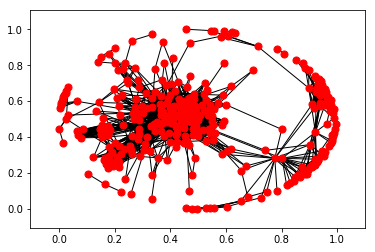

In [26]:
# draw network
nx.draw_networkx(g_orig, with_labels=False, node_size=50, node_color='r')
plt.show()

## 2. Adamic-Adar

In [84]:
# Calculate, store Adamic-Index scores in array
aa_matrix = np.zeros(g_adj.shape)
for u, v, p in nx.adamic_adar_index(g): # (u, v) = node indices, p = Adamic-Adar index
    aa_matrix[u][v] = p
    aa_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
aa_matrix = aa_matrix / aa_matrix.max()

In [102]:
# Calculate ROC AUC and Average Precision
aa_roc_auc = roc_auc_score(g_adj, aa_matrix)
aa_ap = average_precision_score(g_adj, aa_matrix)

print "ROC AUC: ", aa_roc_auc
print "Average Precision: ", aa_ap

ROC AUC:  0.38392127091
Average Precision:  0.0332269206143


## 3. Jaccard Coefficient

In [93]:
# Calculate, store Adamic-Index scores in array
jc_matrix = np.zeros(g_adj.shape)
for u, v, p in nx.jaccard_coefficient(g): # (u, v) = node indices, p = Jaccard coefficient
    jc_matrix[u][v] = p
    jc_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
jc_matrix = jc_matrix / jc_matrix.max()

In [101]:
# Calculate ROC AUC and Average Precision
jc_roc_auc = roc_auc_score(g_adj, jc_matrix)
jc_ap = average_precision_score(g_adj, jc_matrix)

print "ROC AUC: ", jc_roc_auc
print "Average Precision: ", jc_ap

ROC AUC:  0.38392127091
Average Precision:  0.0332269206143


## 4. Preferential Attachment

In [88]:
# Calculate, store Adamic-Index scores in array
pa_matrix = np.zeros(g_adj.shape)
for u, v, p in nx.preferential_attachment(g): # (u, v) = node indices, p = Jaccard coefficient
    pa_matrix[u][v] = p
    pa_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
pa_matrix = pa_matrix / pa_matrix.max()

In [103]:
# Calculate ROC AUC and Average Precision
pa_roc_auc = roc_auc_score(g_adj, pa_matrix)
pa_ap = average_precision_score(g_adj, pa_matrix)

print "ROC AUC: ", pa_roc_auc
print "Average Precision: ", pa_ap

ROC AUC:  0.00157711307747
Average Precision:  0.0227164101038
